In [1]:
import os
import random
from collections import defaultdict
from tqdm.autonotebook import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import cv2
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.nn.functional as F

from sklearn.metrics import balanced_accuracy_score

import warnings
# filter warnings
warnings.filterwarnings('ignore')

/var/folders/7x/q4zhf1wx08z6l2f4bqz5b8dc0000gn/T/ipykernel_73814/3081382395.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
data_path = '../data/Module_3_Lecture_1_SIGNS_dataset/'
splits = ['train', 'test']

## Baseline

In [3]:
class SIGNSDataset(Dataset):
    def __init__(self, data_dir, transform):      
        #store filenames
        self.filenames = os.listdir(data_dir)
        self.filenames = [os.path.join(data_dir, f) for f in self.filenames if f.endswith('.jpg')]
        #the first character of the filename contains the label
        self.labels = [int(filename.split('/')[-1][0]) for filename in self.filenames]
        self.transform = transform

    def __len__(self):
        #return size of dataset
        return len(self.filenames)

    def __getitem__(self, idx):
        #open image, apply transforms and return with label
        image = Image.open(self.filenames[idx])  # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

In [4]:
train_transformer = T.Compose([
    T.Resize(64),              # resize the image to 64x64 
    T.RandomHorizontalFlip(),  # randomly flip image horizontally
    T.ToTensor()])             # transform it into a PyTorch Tensor

test_transformer = T.Compose([
    T.Resize(64),
    T.ToTensor()])

In [5]:
train_dataset = SIGNSDataset(f'{data_path}train_signs/', train_transformer)
test_dataset = SIGNSDataset(f'{data_path}test_signs/', test_transformer)

In [6]:
train_dataset.filenames[:5]

['../data/Module_3_Lecture_1_SIGNS_dataset/train_signs/5_IMG_5556.jpg',
 '../data/Module_3_Lecture_1_SIGNS_dataset/train_signs/3_IMG_6138.jpg',
 '../data/Module_3_Lecture_1_SIGNS_dataset/train_signs/5_IMG_5542.jpg',
 '../data/Module_3_Lecture_1_SIGNS_dataset/train_signs/3_IMG_6104.jpg',
 '../data/Module_3_Lecture_1_SIGNS_dataset/train_signs/5_IMG_5595.jpg']

In [7]:
class BaselineModel(nn.Module):

    def __init__(self, ): 
        super().__init__()
        self.num_channels = 32
        
        # each of the convolution layers below have the arguments (input_channels, output_channels, filter_size,
        # stride, padding). We also include batch normalisation layers that help stabilise training.

        self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride=1, padding=1)

        # 2 fully connected layers to transform the output of the convolution layers to the final output
        self.fc1 = nn.Linear(8*8*self.num_channels*4, self.num_channels*4)
        self.fc2 = nn.Linear(self.num_channels*4, 6)       

    def forward(self, s):
        #                                                  -> batch_size x 3 x 64 x 64
        # we apply the convolution layers, followed by batch normalisation, maxpool and relu x 3
        s = self.conv1(s)                                   # batch_size x num_channels x 64 x 64
        s = F.relu(F.max_pool2d(s, 2))                      # batch_size x num_channels x 32 x 32
        s = self.conv2(s)                                   # batch_size x num_channels*2 x 32 x 32
        s = F.relu(F.max_pool2d(s, 2))                      # batch_size x num_channels*2 x 16 x 16
        s = self.conv3(s)                                   # batch_size x num_channels*4 x 16 x 16
        s = F.relu(F.max_pool2d(s, 2))                      # batch_size x num_channels*4 x 8 x 8

        # flatten the output for each image
        s = s.view(-1, 8*8*self.num_channels*4)             # batch_size x 8*8*num_channels*4

        # apply 2 fully connected layers with dropout
        s = F.relu(self.fc1(s))                             # batch_size x self.num_channels*4
        s = self.fc2(s)                                     # batch_size x 6

        # apply log softmax on each image's output (this is recommended over applying softmax
        # since it is numerically more stable)
        return F.log_softmax(s, dim=1)


In [9]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print("Використовується пристрій:", device)

Використовується пристрій: mps


In [10]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=32, 
                              shuffle=True,
                              num_workers=0)

test_dataloader = DataLoader(test_dataset,
                             batch_size=32, 
                             shuffle=False,
                             num_workers=0)

In [11]:
# Define the model and optimizer
model = BaselineModel().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [12]:
model

BaselineModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)

In [14]:
# Train the model
criterion = nn.CrossEntropyLoss().to(device)

train_losses = []
train_accs = []

test_losses = []
test_accs = []

num_epochs = 15

for epoch in tqdm(range(num_epochs)):
    
    # Train step
    model.train()
    train_epoch_loss = []
    train_epoch_acc = []
    
    for i, (train_batch, labels_batch) in tqdm(enumerate(train_dataloader)):
        train_batch, labels_batch = train_batch.to(device), labels_batch.to(device)

        # compute model output and loss
        output_batch = model(train_batch)
        loss = criterion(output_batch, labels_batch)

        # clear previous gradients, compute gradients of all variables wrt loss
        optimizer.zero_grad()
        loss.backward()

        # performs updates using calculated gradients
        optimizer.step()
        
        batch_loss = loss.cpu().detach().numpy()
        batch_acc = balanced_accuracy_score(np.argmax(output_batch.cpu().detach().numpy(), axis=1),
                                            labels_batch.cpu().detach().numpy())
        
        train_epoch_loss.append(batch_loss)
        train_epoch_acc.append(batch_acc)
    
    print(f'Train epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(train_epoch_loss):.4f}, Acc: {np.mean(train_epoch_acc)}')
    train_accs.append(np.mean(train_epoch_acc))
    train_losses.append(np.mean(train_epoch_loss))
    
    # Eval step
    model.eval()
    test_epoch_loss = []
    test_epoch_acc = []
    
    with torch.no_grad():
        for i, (test_batch, labels_batch) in enumerate(test_dataloader):
            test_batch, labels_batch = test_batch.to(device), labels_batch.to(device)

            # compute model output and loss
            output_batch = model(test_batch)
            loss = criterion(output_batch, labels_batch)

            batch_loss = loss.cpu().detach().numpy()
            batch_acc = balanced_accuracy_score(np.argmax(output_batch.cpu().detach().numpy(), axis=1),
                                                labels_batch.cpu().detach().numpy())

            test_epoch_loss.append(batch_loss)
            test_epoch_acc.append(batch_acc)
    
    print(f'Test epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(test_epoch_loss):.4f}, Acc: {np.mean(test_epoch_acc)}')        
    test_accs.append(np.mean(test_epoch_acc))
    test_losses.append(np.mean(test_epoch_loss))


  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train epoch [1/15], Loss: 1.7945, Acc: 0.17038690476190477
Test epoch [1/15], Loss: 1.7797, Acc: 0.1640625


0it [00:00, ?it/s]

Train epoch [2/15], Loss: 1.6551, Acc: 0.3530797948956101
Test epoch [2/15], Loss: 1.5183, Acc: 0.5507837301587302


0it [00:00, ?it/s]

Train epoch [3/15], Loss: 1.2929, Acc: 0.5747335121145674
Test epoch [3/15], Loss: 1.0740, Acc: 0.7186011904761904


0it [00:00, ?it/s]

Train epoch [4/15], Loss: 0.9462, Acc: 0.6857315097756275
Test epoch [4/15], Loss: 0.8102, Acc: 0.7088492063492063


0it [00:00, ?it/s]

Train epoch [5/15], Loss: 0.7200, Acc: 0.7800503282120929
Test epoch [5/15], Loss: 0.6053, Acc: 0.8230654761904762


0it [00:00, ?it/s]

Train epoch [6/15], Loss: 0.5072, Acc: 0.8468220368955663
Test epoch [6/15], Loss: 0.4011, Acc: 0.8959160052910052


0it [00:00, ?it/s]

Train epoch [7/15], Loss: 0.4436, Acc: 0.8443538678097501
Test epoch [7/15], Loss: 0.3537, Acc: 0.8851957070707072


0it [00:00, ?it/s]

Train epoch [8/15], Loss: 0.3421, Acc: 0.8781937017231135
Test epoch [8/15], Loss: 0.3561, Acc: 0.8710813492063492


0it [00:00, ?it/s]

Train epoch [9/15], Loss: 0.3283, Acc: 0.8917320968791557
Test epoch [9/15], Loss: 0.3369, Acc: 0.8759424603174603


0it [00:00, ?it/s]

Train epoch [10/15], Loss: 0.2514, Acc: 0.9092081529581529
Test epoch [10/15], Loss: 0.4154, Acc: 0.8491567460317461


0it [00:00, ?it/s]

Train epoch [11/15], Loss: 0.2754, Acc: 0.906491561270973
Test epoch [11/15], Loss: 0.2819, Acc: 0.9268518518518519


0it [00:00, ?it/s]

Train epoch [12/15], Loss: 0.1807, Acc: 0.9413591446679682
Test epoch [12/15], Loss: 0.2608, Acc: 0.9137731481481481


0it [00:00, ?it/s]

Train epoch [13/15], Loss: 0.1493, Acc: 0.9607646846617435
Test epoch [13/15], Loss: 0.2922, Acc: 0.9265211640211639


0it [00:00, ?it/s]

Train epoch [14/15], Loss: 0.1548, Acc: 0.9475256769374418
Test epoch [14/15], Loss: 0.2952, Acc: 0.9185846560846561


0it [00:00, ?it/s]

Train epoch [15/15], Loss: 0.1235, Acc: 0.9593446722123192
Test epoch [15/15], Loss: 0.2739, Acc: 0.9370039682539683


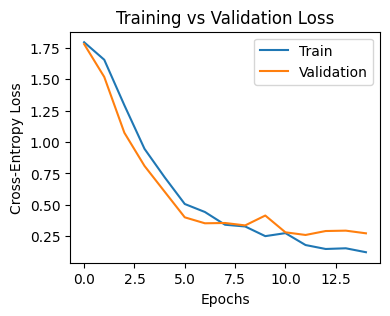

In [15]:
plt.figure(figsize=(4, 3))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Training vs Validation Loss')
plt.show()

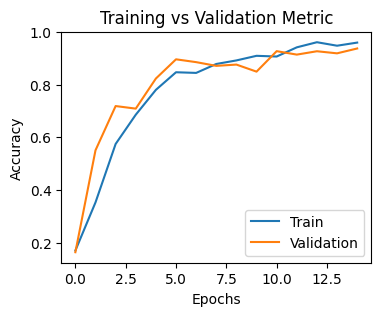

In [16]:
plt.figure(figsize=(4, 3))
plt.plot(train_accs, label='Train')
plt.plot(test_accs, label='Validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Metric')
plt.show()